## Anchor Direction Visualization Framework: DeepSurv trained on the SUPPORT dataset (where the encoder has a Euclidean norm 1 constraint) -- using different numbers of clusters now with a Gaussian mixture model

This notebook is a modified and slightly shortened version of the main SUPPORT DeepSurv (norm 1 constraint) notebook, where the main difference is just that we try multiple numbers of clusters. We now cluster using a Gaussian mixture model instead.

### Loading in data (including some outputs from the already trained neural survival analysis model)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = ['sans-serif', 'Arial']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import scipy.stats

from visualization_utils import get_experiment_data, l2_normalize_rows, longest_common_prefix, \
    compute_median_survival_times

Some explanation of the variables below:

- `emb_direction`: these are embedding vectors for anchor direction estimation data
- `emb_vis`: these are embedding vectors for the visualization raw inputs
- `raw_direction`: raw inputs of the anchor direction estimation data
- `raw_vis`: visualization raw inputs
- `label_direction`: survival labels (2 columns: column 0 stores observed times and column 1 stores event indicators) of the anchor direction estimation data
- `label_vis`: survival labels of the visualization raw inputs
- `unique_train_times`: discretized time grid used for the predicted survival curves
- `predicted_surv_vis`: predicted survival curves of the visualization raw inputs (so each visualization raw input has a predicted survival curve that is specified for the time grid given by `unique_train_times`

In [2]:
emb_direction, emb_vis, raw_direction, raw_vis, label_direction, label_vis, \
    _, unique_train_times, predicted_surv_vis \
        = get_experiment_data('support', '../train_models/output_tabular_hypersphere')

For example, in this case, there are 665 anchor estimation data points and the embedding dimension is 10:

In [3]:
emb_direction.shape

(665, 10)

### 2D PCA plot of the visualization data

In [4]:
median_surv_time_estimates = compute_median_survival_times(predicted_surv_vis, unique_train_times)

Text(0.5, 1.0, '2D PCA plot of a DeepSurv embedding space (SUPPORT dataset)')

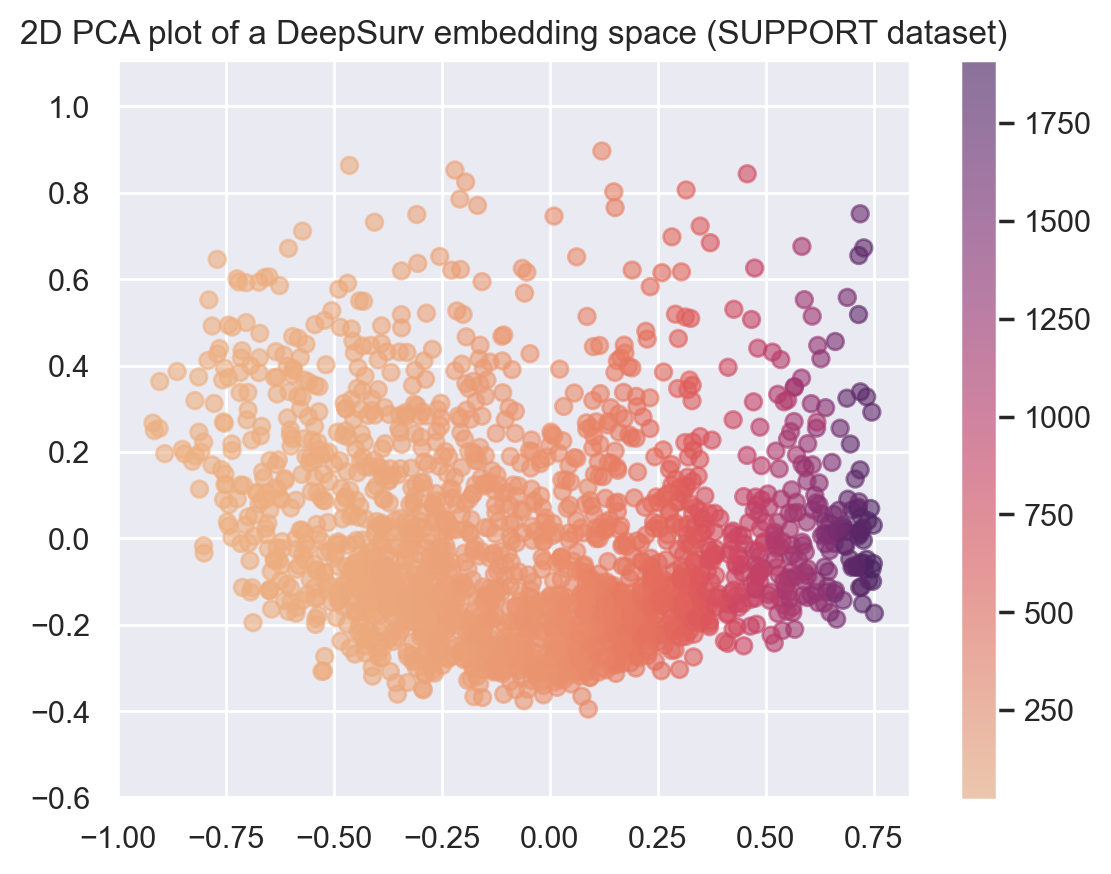

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_vis_pca_2d = pca.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_pca_2d[:, 0], emb_vis_pca_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D PCA plot of a DeepSurv embedding space (SUPPORT dataset)')
# plt.savefig('support-embedding-space-pca-hypersphere.pdf', bbox_inches='tight')

### 2D t-SNE plot of the visualization data

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '2D t-SNE plot of a DeepSurv embedding space (SUPPORT dataset)')

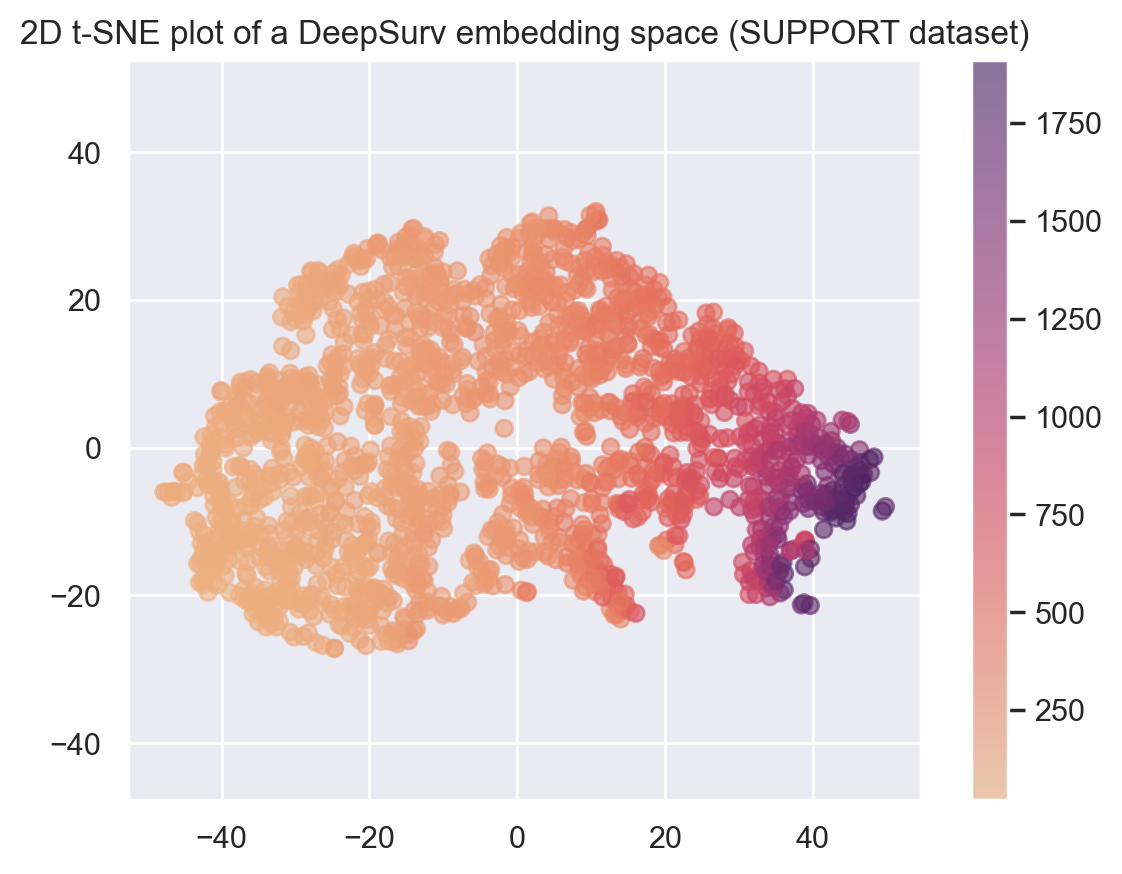

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=3676767249)
emb_vis_tsne_2d = tsne.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_tsne_2d[:, 0], emb_vis_tsne_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D t-SNE plot of a DeepSurv embedding space (SUPPORT dataset)')
# plt.savefig('support-embedding-space-tsne-hypersphere.pdf', bbox_inches='tight')

### For different choices for the number of components, fit a mixture of von Mises-Fisher distributions

We use the Expectation-Maximization algorithm implementation by Minyoung Kim: https://github.com/minyoungkim21/vmf-lib

In [7]:
from sklearn.mixture import GaussianMixture
from lifelines.statistics import pairwise_logrank_test

seed = 1861600023

n_init = 100
n_clusters_to_try = list(range(2, 11))
logrank_p_values = []
cluster_assignments = []

for n_clusters in n_clusters_to_try:
    print('Trying %d clusters...' % n_clusters)
    
    model = GaussianMixture(n_clusters, random_state=seed, n_init=n_init)
    cluster_assignment = model.fit_predict(emb_direction)

    result = pairwise_logrank_test(label_direction[:, 0],
                                   cluster_assignment,
                                   label_direction[:, 1])
    logrank_p_values.append(result.p_value)
    cluster_assignments.append(cluster_assignment)

Trying 2 clusters...
Trying 3 clusters...
Trying 4 clusters...
Trying 5 clusters...
Trying 6 clusters...
Trying 7 clusters...
Trying 8 clusters...
Trying 9 clusters...
Trying 10 clusters...


Below, we make a violin plot for helping us select the number of clusters to use.

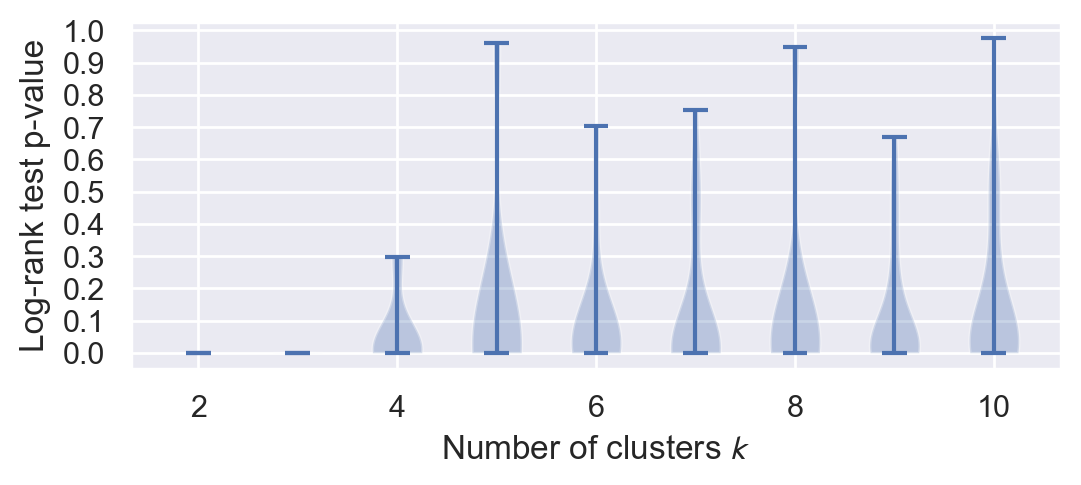

In [8]:
plt.figure(figsize=(6, 2.25))
plt.violinplot(logrank_p_values, n_clusters_to_try)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Log-rank test p-value')
plt.yticks(np.linspace(0, 1, 11))
plt.savefig('support-logrank-pvalue-vs-nclusters-hypersphere-gmm.pdf', bbox_inches='tight')

### Using different clusters' anchor directions, make various visualizations

In [9]:
# code that discretizes the all raw features (discrete and continuous) for raw feature probability heatmap
# visualizations (this code is specific to the SUPPORT dataset but can be modified for other tabular data)

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

def transform(raw_features, continuous_n_bins=5):
    feature_names = ['age', 'female', 'race', 'number of comorbidities',
                     'diabetes', 'dementia', 'cancer', 'mean arterial blood pressure',
                     'heart rate', 'respiration rate', 'temperature', 'white blood count',
                     'serum sodium', 'serum creatinine']
    binary_indices = [1, 4, 5]
    continuous_indices = [0, 3, 7, 8, 9, 10, 11, 12, 13]
    discretized_features = []
    discretized_feature_names = []
    all_n_bins_to_use = []
    for idx in continuous_indices:
        n_bins_to_use = continuous_n_bins
        discretizer = KBinsDiscretizer(n_bins=n_bins_to_use,
                                       strategy='quantile',
                                       encode='onehot-dense')
        new_features = discretizer.fit_transform(raw_features[:, idx].reshape(-1, 1).astype(float))
        if discretizer.n_bins_[0] != n_bins_to_use:
            n_bins_to_use = discretizer.n_bins_[0]

        if n_bins_to_use > 1:
            discretized_features.append(new_features)
            for bin_idx in range(n_bins_to_use):
                if bin_idx == 0:
                    discretized_feature_names.append(feature_names[idx] + ' bin#1(-inf,%.2f)' % discretizer.bin_edges_[0][bin_idx+1])
                elif bin_idx == n_bins_to_use - 1:
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,inf)' % (n_bins_to_use, discretizer.bin_edges_[0][bin_idx]))
                else:
                    # print(discretizer.bin_edges_[0][bin_idx:bin_idx+2])
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,%.2f)' % tuple([bin_idx + 1] + list(discretizer.bin_edges_[0][bin_idx:bin_idx+2])))
        all_n_bins_to_use.append(n_bins_to_use)
    for idx in binary_indices:
        discretized_features.append(raw_features[:, idx].reshape(-1, 1).astype(float))
        discretized_feature_names.append(feature_names[idx])
        all_n_bins_to_use.append(1)

    # race
    discretizer = OneHotEncoder(sparse=False, categories=[[0, 1, 2, 3, 4, 5]])
    discretized_features.append(discretizer.fit_transform(raw_features[:, 2].reshape(-1, 1).astype(float)))
    discretized_feature_names.extend(['race cat#1(unspecified)',
                                      'race cat#2(asian)',
                                      'race cat#3(black)',
                                      'race cat#4(hispanic)',
                                      'race cat#5(other)',
                                      'race cat#6(white)'])
    all_n_bins_to_use.append(6)

    # cancer
    discretizer = OneHotEncoder(sparse=False, categories=[[0, 1, 2]])
    discretized_features.append(discretizer.fit_transform(raw_features[:, 6].reshape(-1, 1).astype(float)))
    discretized_feature_names.extend(['cancer cat#1(no)',
                                      'cancer cat#2(yes)',
                                      'cancer cat#3(metastatic)'])
    all_n_bins_to_use.append(3)
    return np.hstack(discretized_features), discretized_feature_names, all_n_bins_to_use

In [10]:
raw_vis_discretized, discretized_feature_names, all_n_bins_to_use = transform(raw_vis)

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[Number of clusters: 3]
[Cluster 1]
1 - age - 1.2913362014770073e-121
2 - temperature - 3.6700990889410586e-115
3 - cancer - 5.47470054463462e-52
4 - serum sodium - 7.553076584703045e-26
5 - mean arterial blood pressure - 1.0582335071064194e-22
6 - number of comorbidities - 1.4785422831472367e-15
7 - dementia - 2.989381868208095e-08
8 - heart rate - 1.9084978151238496e-07
9 - female - 1.6356736356978061e-06
10 - respiration rate - 8.067425023951515e-05
11 - diabetes - 0.0013425591182657402
12 - white blood count - 0.003367895408992054
13 - race - 0.01674867999220353
14 - serum creatinine - 0.05323362729004167

[Cluster 2]
1 - cancer - 2.4178838139399922e-150
2 - age - 1.1011274254446278e-111
3 - temperature - 2.8526180914140386e-20
4 - mean arterial blood pressure - 9.618966217735519e-20
5 - number of comorbidities - 1.486409040389678e-17
6 - dementia - 3.591196196562937e-13
7 - serum sodium - 2.8101685439997557e-10
8 - diabetes - 2.6037716130775e-05
9 - race - 0.0003256482564278572
10

/tmp/ipykernel_4002802/115656810.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
/tmp/ipykernel_4002802/115656810.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


Cluster 3 : median survival time estimate 48.0
Cluster 1 : median survival time estimate 156.0
Cluster 2 : median survival time estimate 1600.0


[Number of clusters: 4]
[Cluster 1]
1 - cancer - 6.2973030540224935e-204
2 - age - 1.7423723906037323e-48
3 - mean arterial blood pressure - 4.588668567280828e-35
4 - temperature - 8.876195068527986e-35
5 - serum creatinine - 9.96485052138198e-26
6 - white blood count - 3.410713899585983e-24
7 - number of comorbidities - 2.9268079319750048e-21
8 - heart rate - 1.9102243633267962e-19
9 - female - 2.10828013532128e-14
10 - race - 5.535027553731704e-11
11 - dementia - 1.3832702392719592e-10
12 - respiration rate - 1.484660850821462e-10
13 - diabetes - 4.929357569031238e-05
14 - serum sodium - 0.00019441618179242718

[Cluster 2]
1 - cancer - 2.320029303981444e-180
2 - age - 5.02460499302006e-92
3 - mean arterial blood pressure - 1.4431189678973756e-19
4 - number of comorbidities - 6.352643766394356e-19
5 - dementia - 2.303667487992166e-13
6 - dia

/tmp/ipykernel_4002802/115656810.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
/tmp/ipykernel_4002802/115656810.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


Cluster 1 : median survival time estimate 46.0
Cluster 2 : median survival time estimate 70.0
Cluster 3 : median survival time estimate 244.0
Cluster 4 : median survival time estimate 1524.0


[Number of clusters: 5]
[Cluster 1]
1 - cancer - 4.868502469538175e-227
2 - temperature - 9.434201423109896e-43
3 - age - 1.9965761733799013e-37
4 - number of comorbidities - 8.376652667291695e-24
5 - female - 1.2105884151826867e-15
6 - mean arterial blood pressure - 1.814192817456155e-15
7 - heart rate - 1.5117136643457066e-12
8 - diabetes - 3.20265200611862e-12
9 - respiration rate - 3.203964266663115e-10
10 - dementia - 8.410117142650537e-09
11 - serum creatinine - 1.533494716228065e-07
12 - white blood count - 4.067825165485232e-07
13 - race - 0.0007011900422546766
14 - serum sodium - 0.0039194572028578385

[Cluster 2]
1 - cancer - 1.0222060846043904e-172
2 - age - 2.583193308109409e-97
3 - number of comorbidities - 1.3464378037532085e-16
4 - mean arterial blood pressure - 3.2629441410330123e

/tmp/ipykernel_4002802/115656810.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
/tmp/ipykernel_4002802/115656810.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


Cluster 4 : median survival time estimate 46.0
Cluster 1 : median survival time estimate 66.0
Cluster 5 : median survival time estimate 88.0
Cluster 3 : median survival time estimate 278.0
Cluster 2 : median survival time estimate 1687.0


[Number of clusters: 6]
[Cluster 1]
1 - cancer - 5.298222093350693e-122
2 - temperature - 9.212879770194941e-87
3 - female - 8.055799564078628e-27
4 - age - 6.166278251782126e-23
5 - white blood count - 1.4155281473563804e-19
6 - respiration rate - 2.9941648942217824e-15
7 - serum creatinine - 1.723999807011723e-14
8 - serum sodium - 2.0014371744735115e-14
9 - number of comorbidities - 5.629594884691329e-13
10 - heart rate - 1.5060451526141333e-12
11 - mean arterial blood pressure - 3.5047267201634284e-12
12 - race - 4.626684559909219e-08
13 - dementia - 0.007304556417729425
14 - diabetes - 0.011954839830000284

[Cluster 2]
1 - cancer - 3.1888955645577706e-193
2 - age - 6.360399689681773e-89
3 - number of comorbidities - 6.62085091353935e-19
4 - mean

/tmp/ipykernel_4002802/115656810.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
/tmp/ipykernel_4002802/115656810.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


Cluster 1 : median survival time estimate 66.0
Cluster 3 : median survival time estimate 69.0
Cluster 5 : median survival time estimate 89.0
Cluster 4 : median survival time estimate 173.0
Cluster 6 : median survival time estimate 271.0
Cluster 2 : median survival time estimate 1753.0


[Number of clusters: 7]
[Cluster 1]
1 - cancer - 1.3119010561694456e-166
2 - age - 1.92406961665985e-127
3 - number of comorbidities - 5.21263558294344e-17
4 - mean arterial blood pressure - 3.957666159011569e-16
5 - temperature - 7.072562205309629e-16
6 - dementia - 7.284635181431647e-14
7 - diabetes - 1.8410637808337353e-06
8 - respiration rate - 3.154819342158906e-06
9 - heart rate - 1.7523812981723467e-05
10 - serum sodium - 2.3023714274163145e-05
11 - serum creatinine - 0.0007653273082139377
12 - race - 0.0007889929586482102
13 - white blood count - 0.00773927865186611
14 - female - 0.0323401645738208

[Cluster 2]
1 - temperature - 1.0888305742432623e-110
2 - age - 4.363873925928616e-105
3 - cancer

/tmp/ipykernel_4002802/115656810.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
/tmp/ipykernel_4002802/115656810.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


Cluster 5 : median survival time estimate 56.0
Cluster 6 : median survival time estimate 74.0
Cluster 7 : median survival time estimate 77.0
Cluster 2 : median survival time estimate 126.0
Cluster 3 : median survival time estimate 322.0
Cluster 4 : median survival time estimate 1114.0
Cluster 1 : median survival time estimate inf




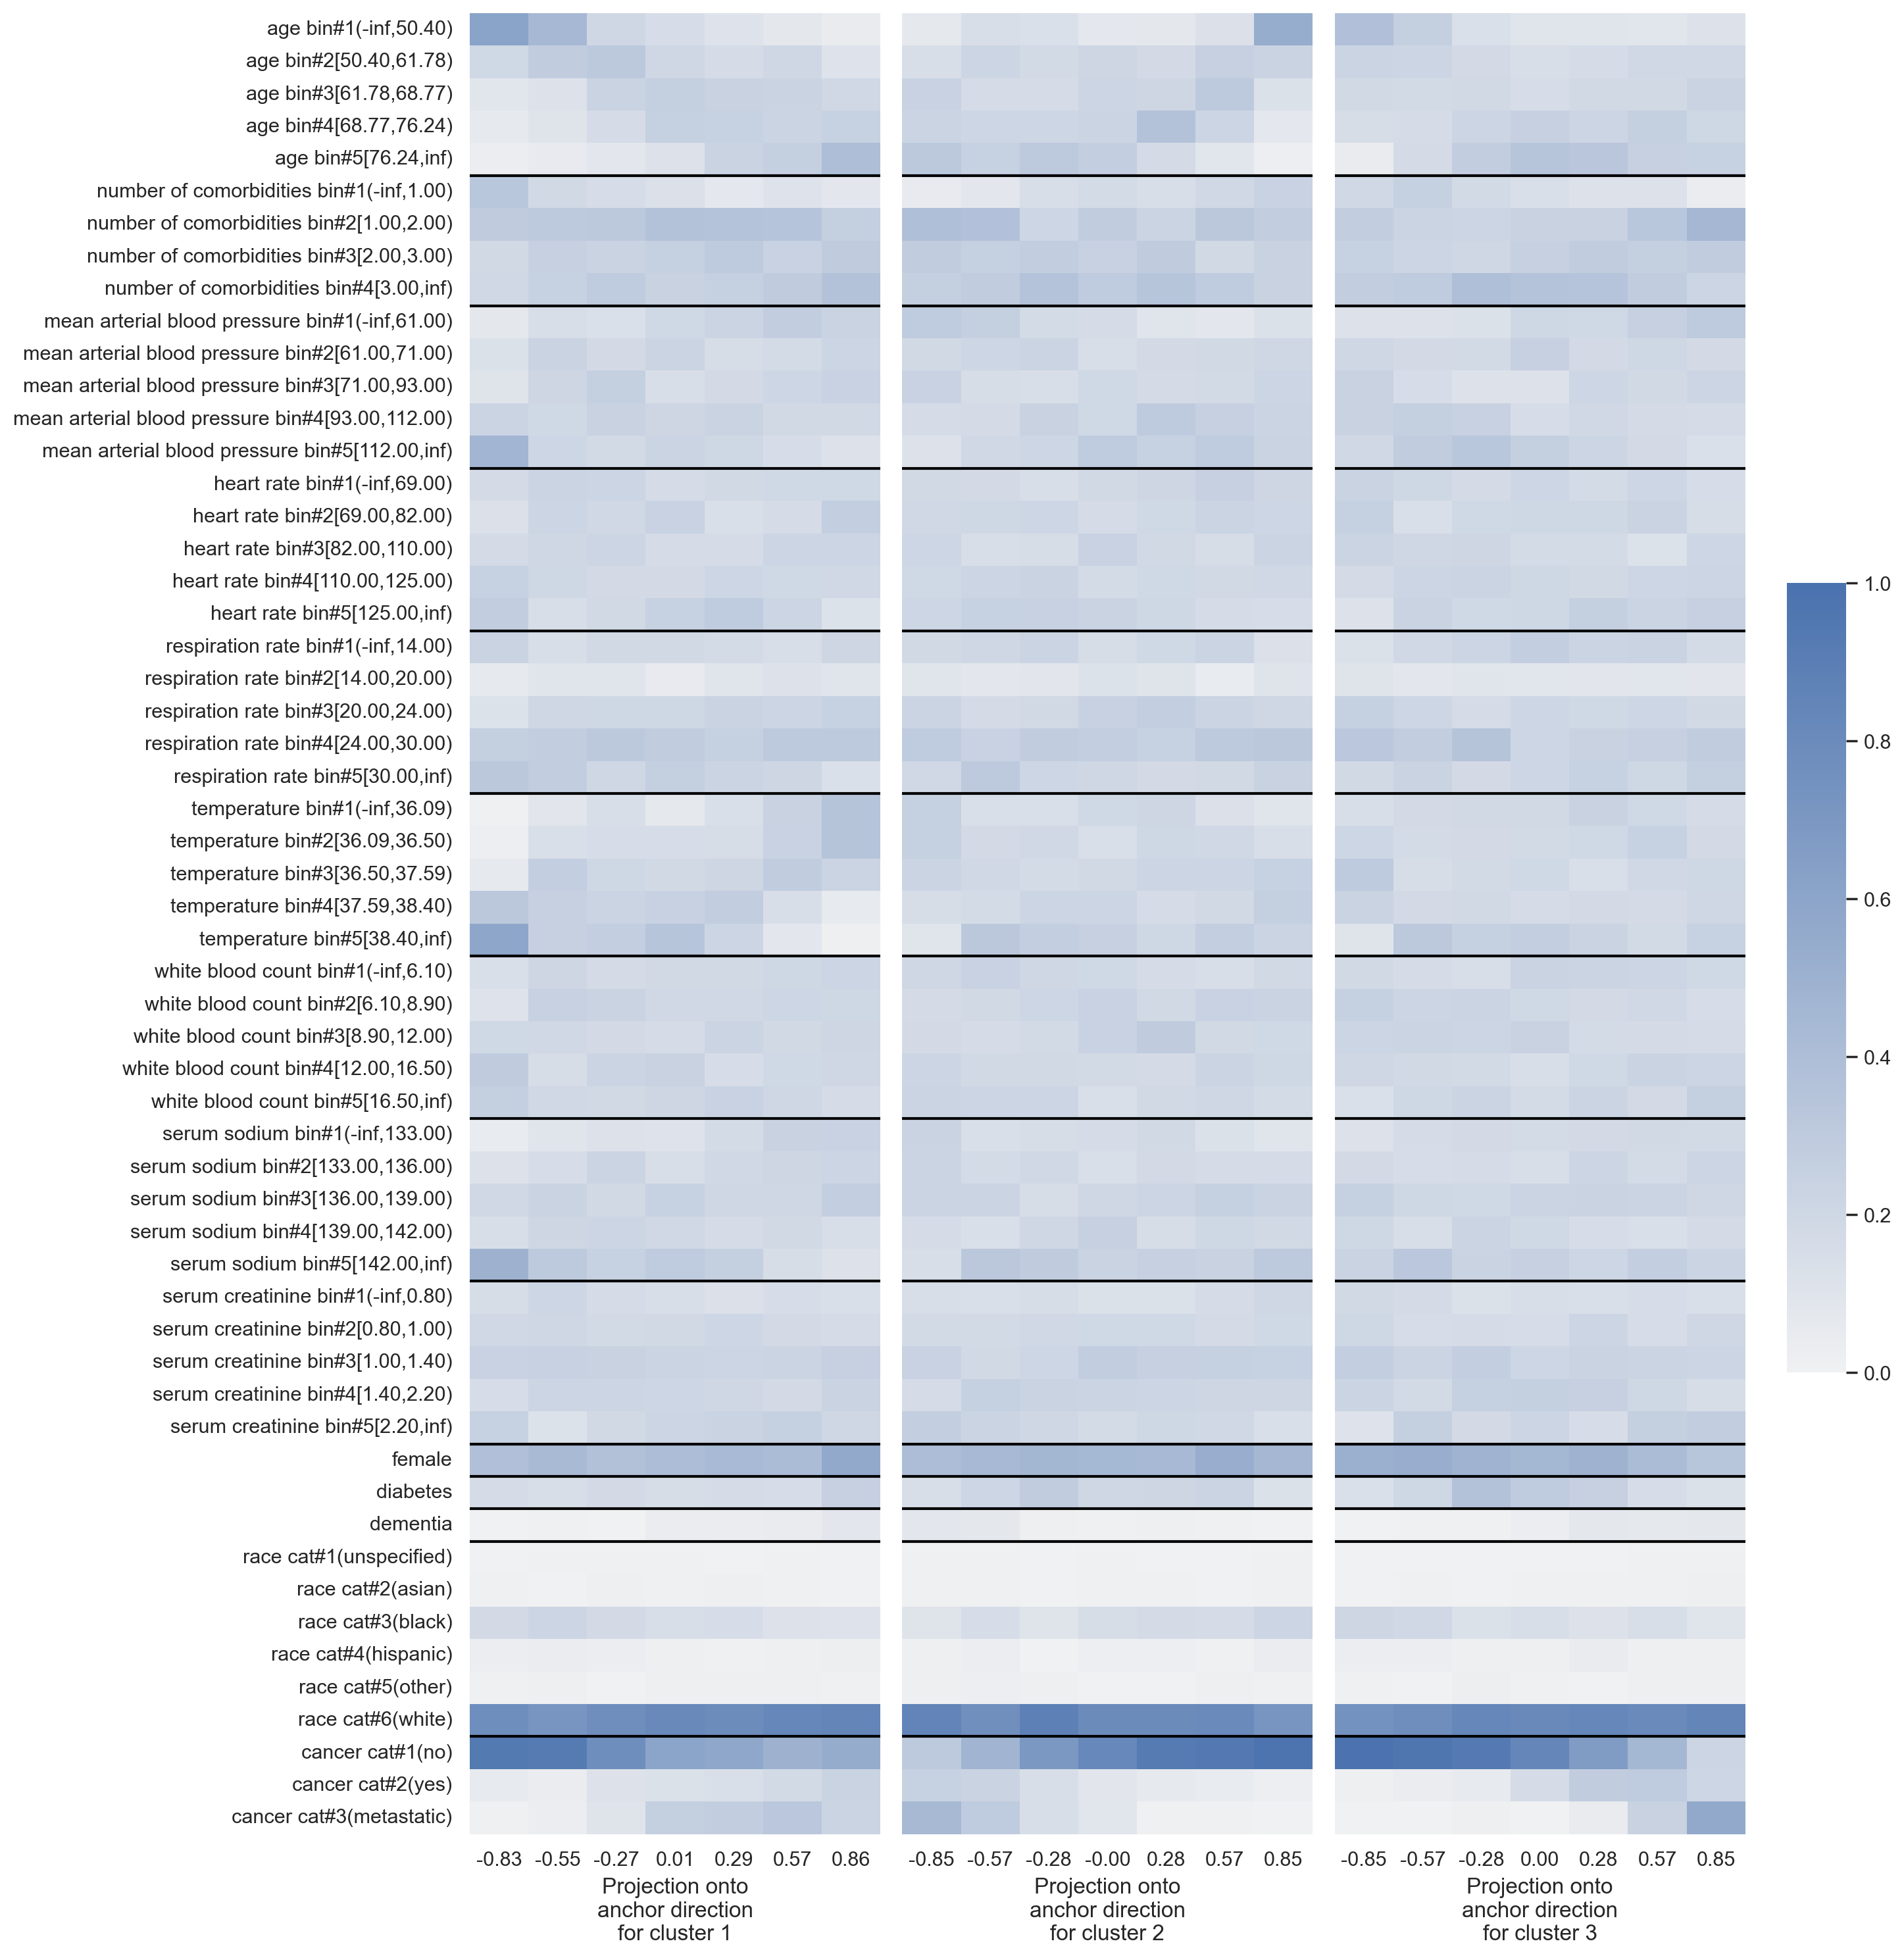

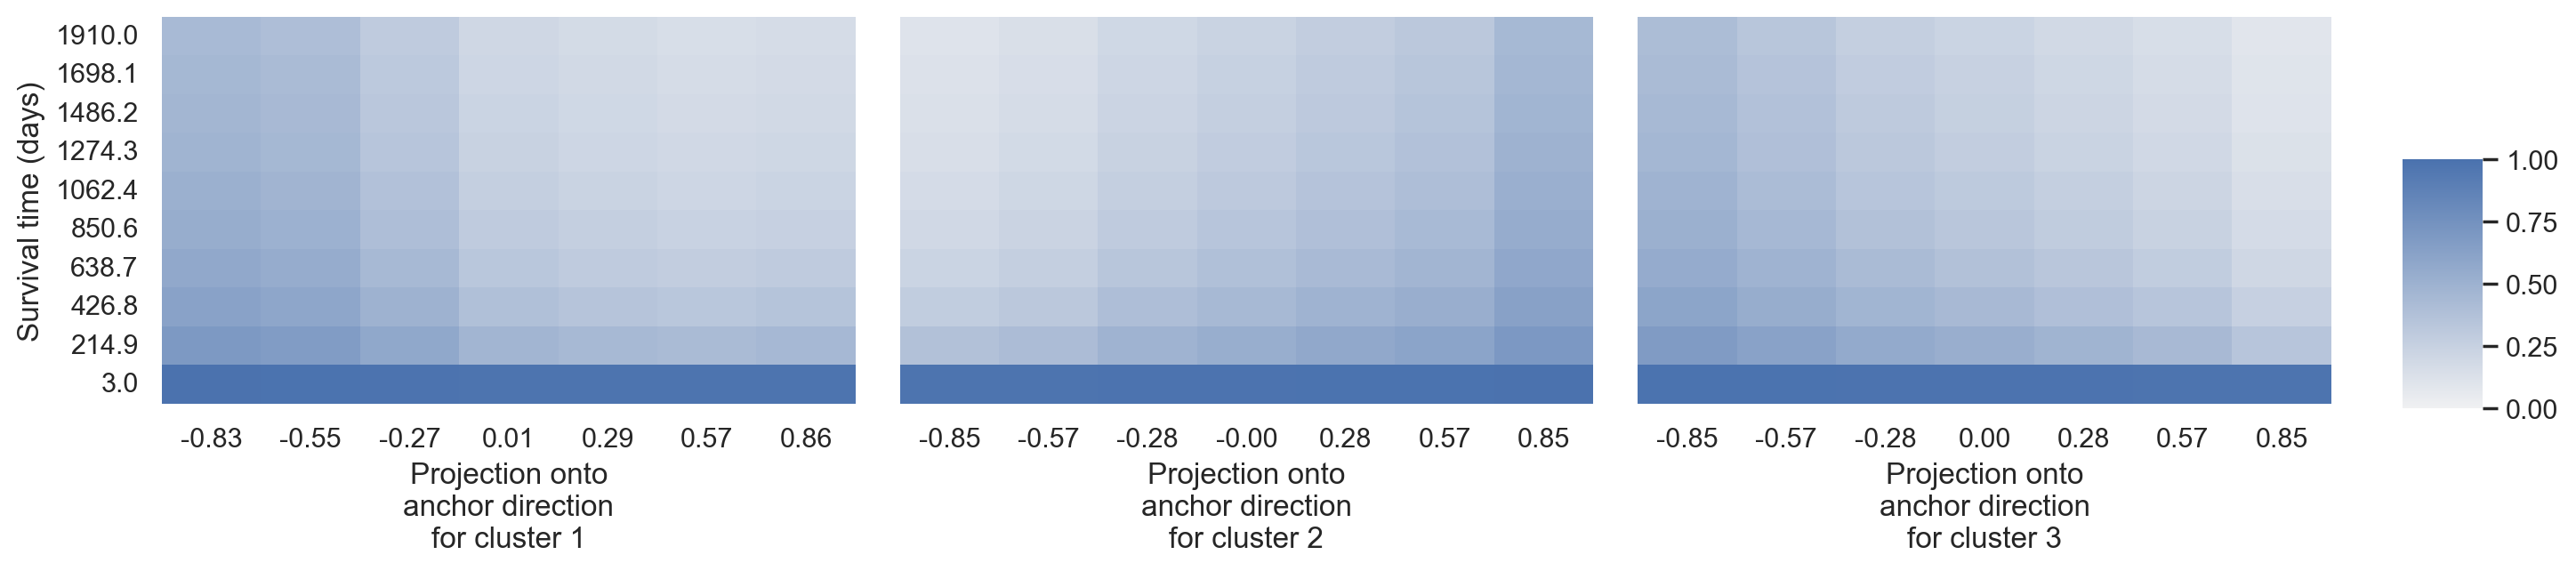

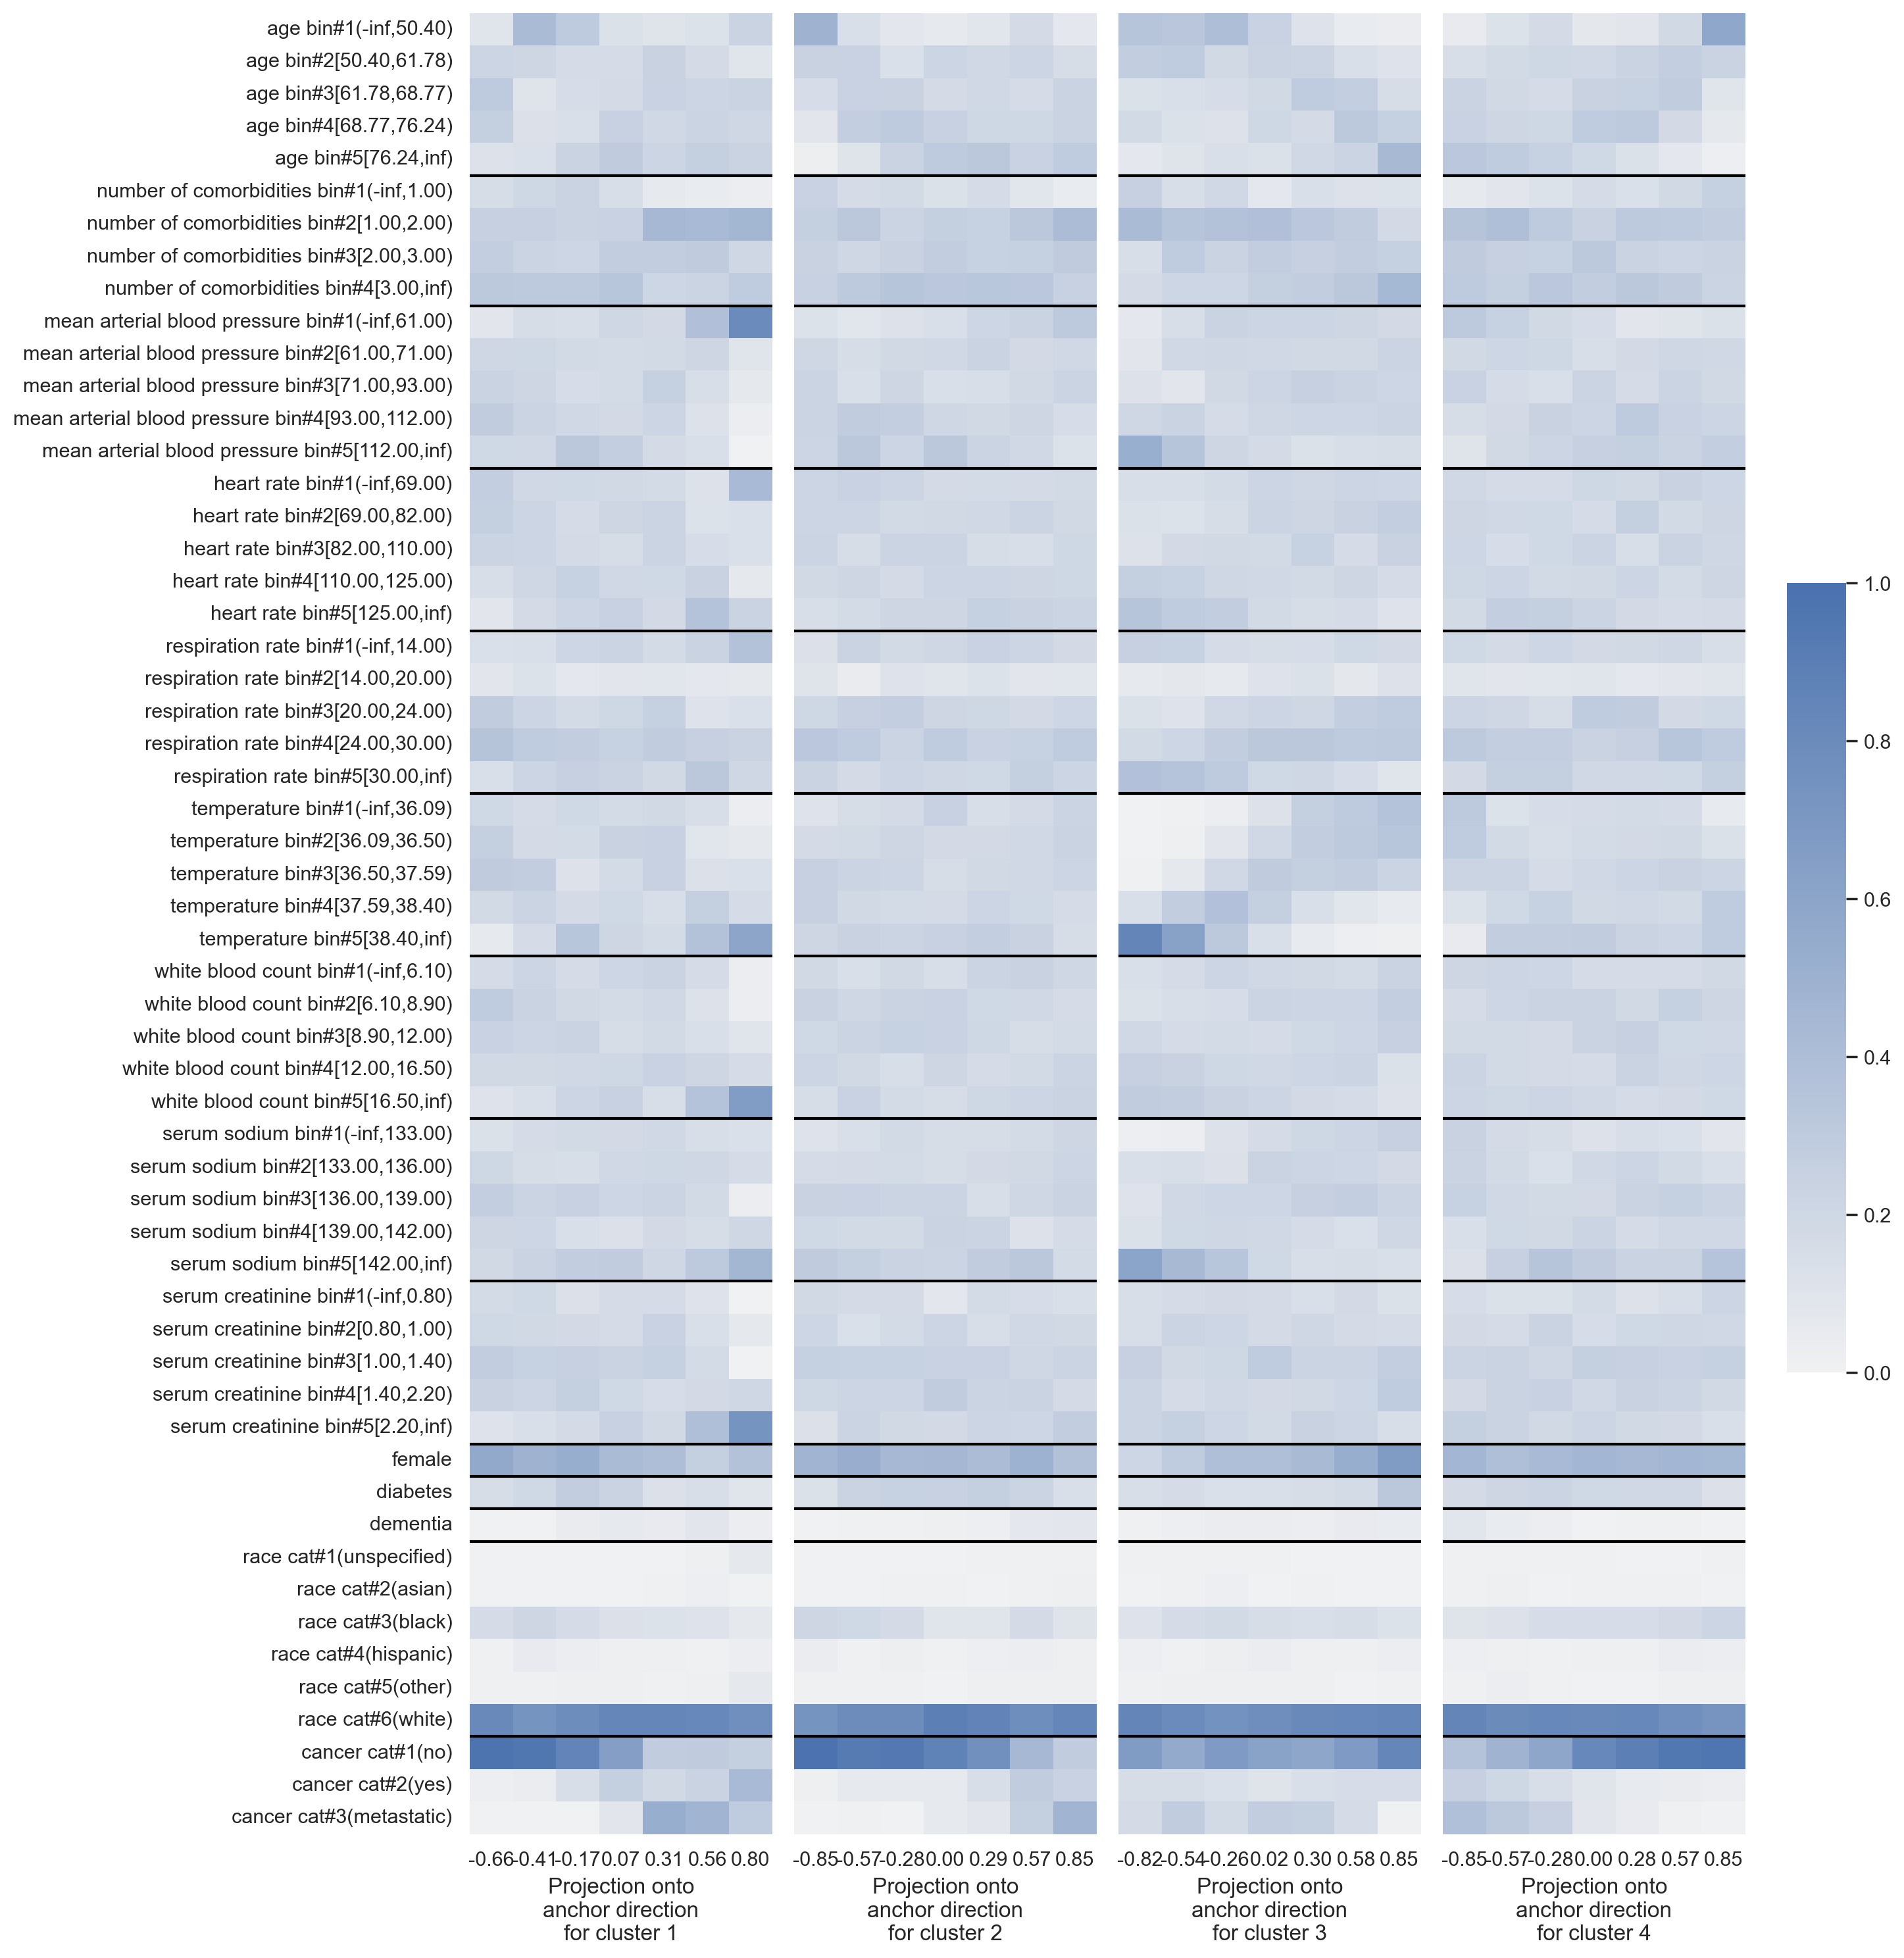

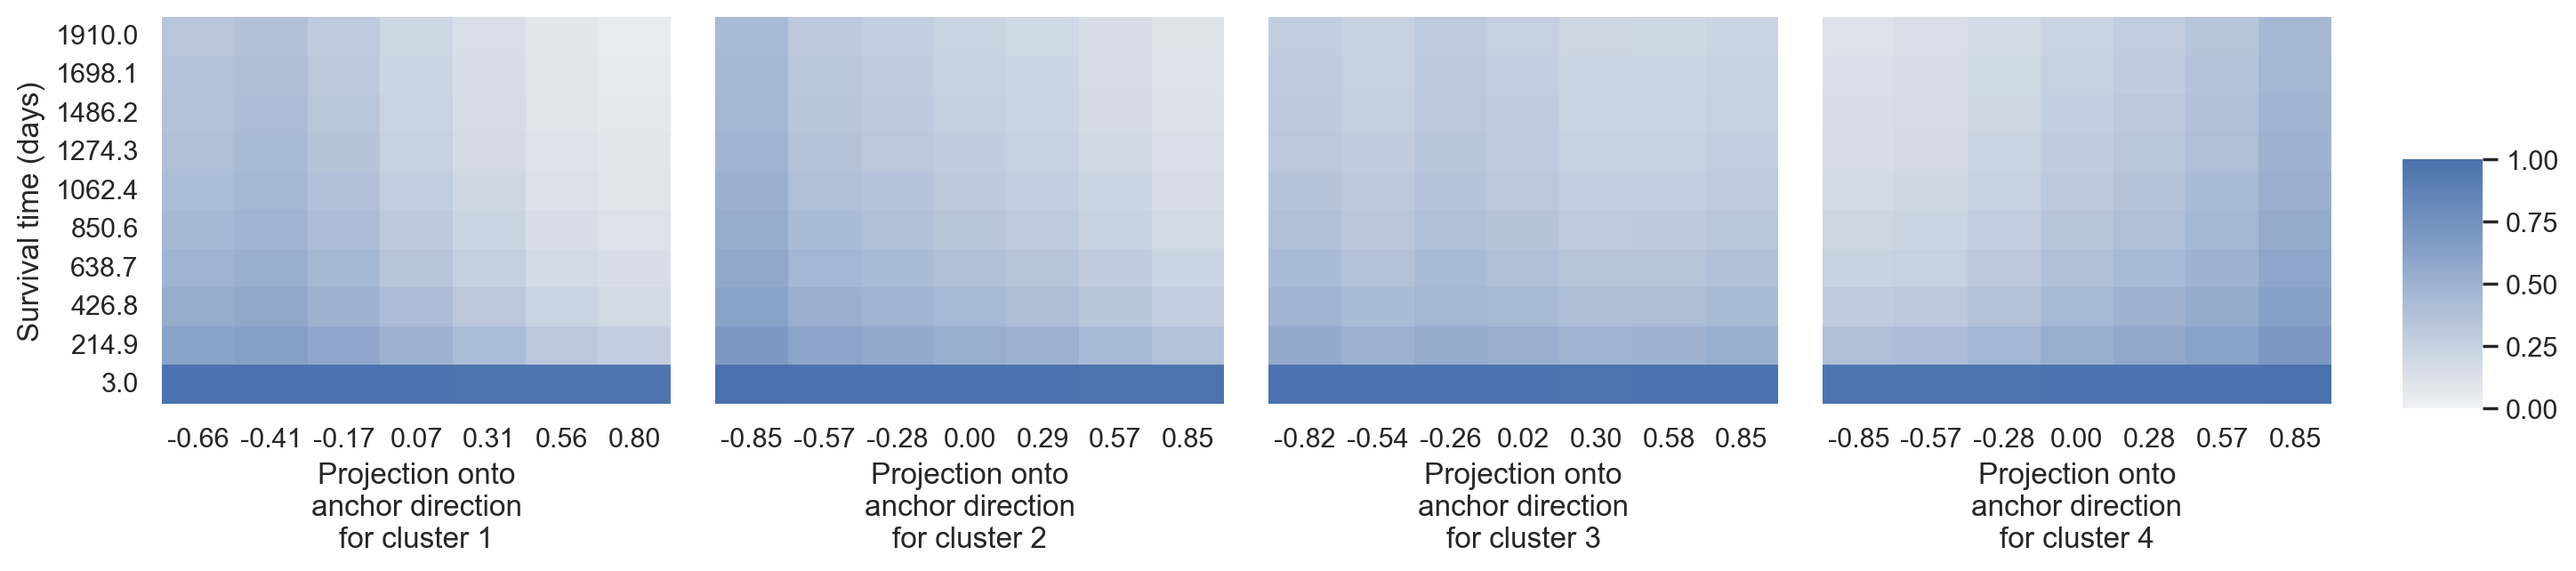

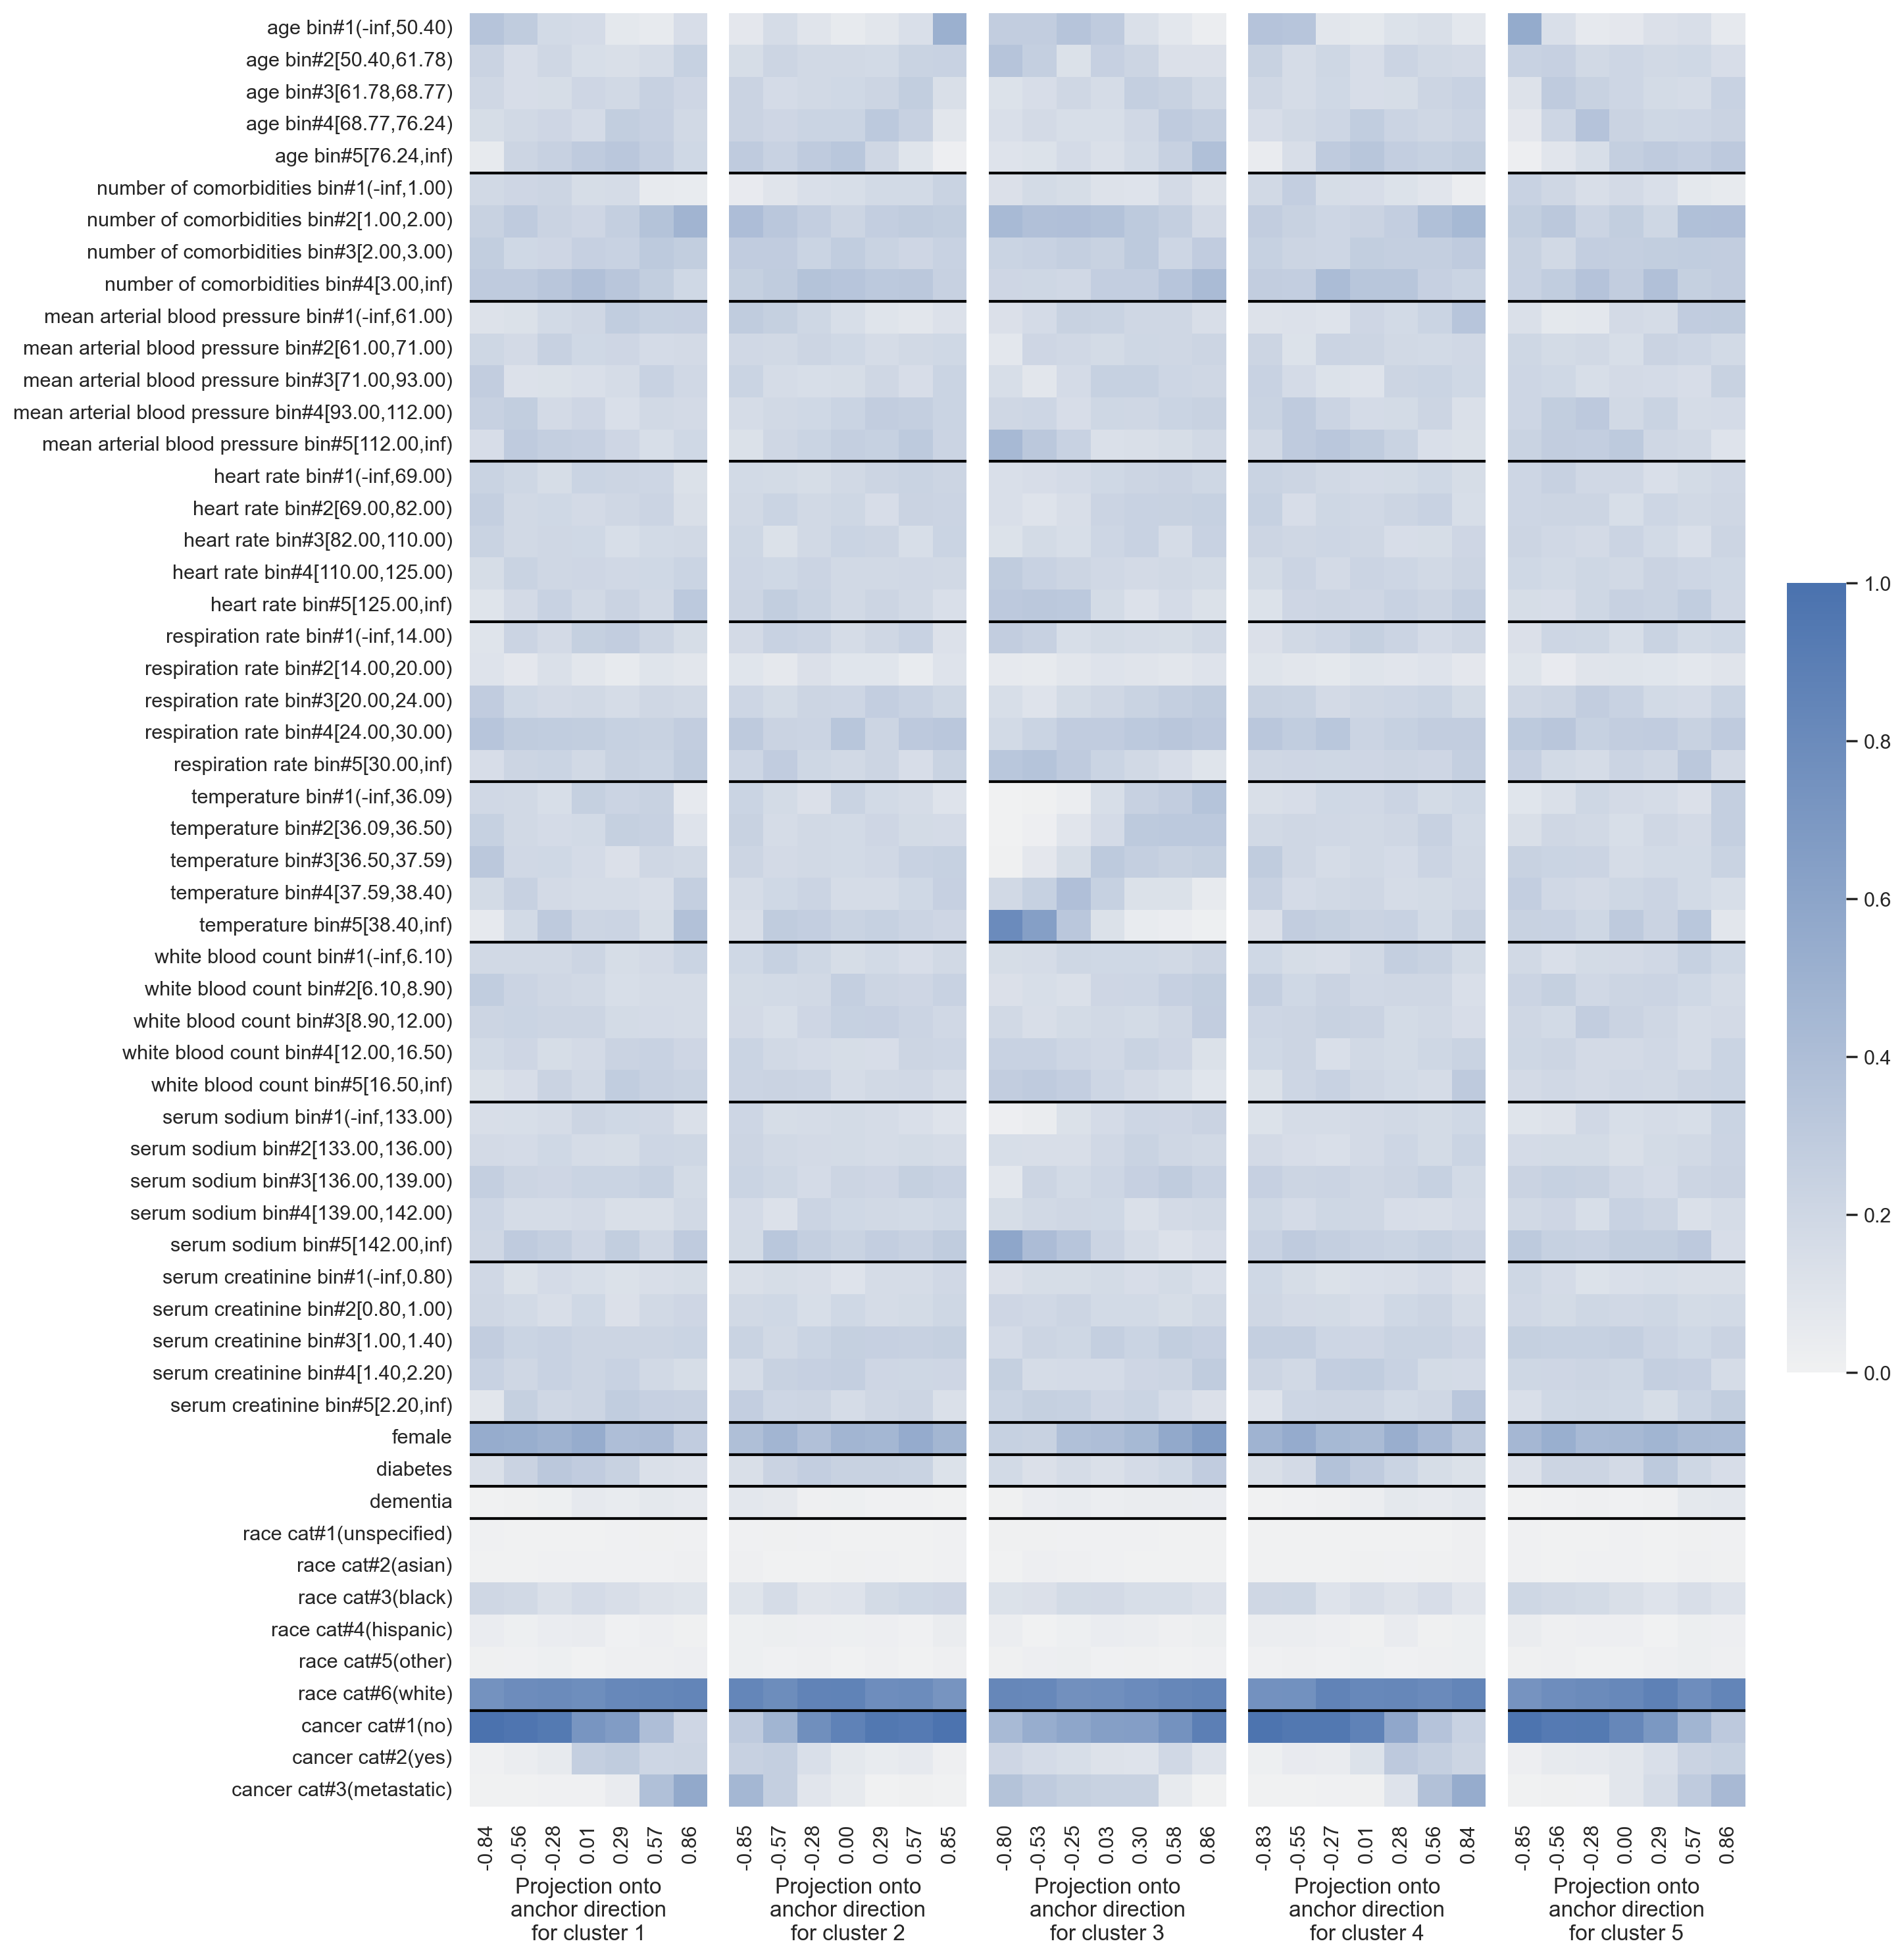

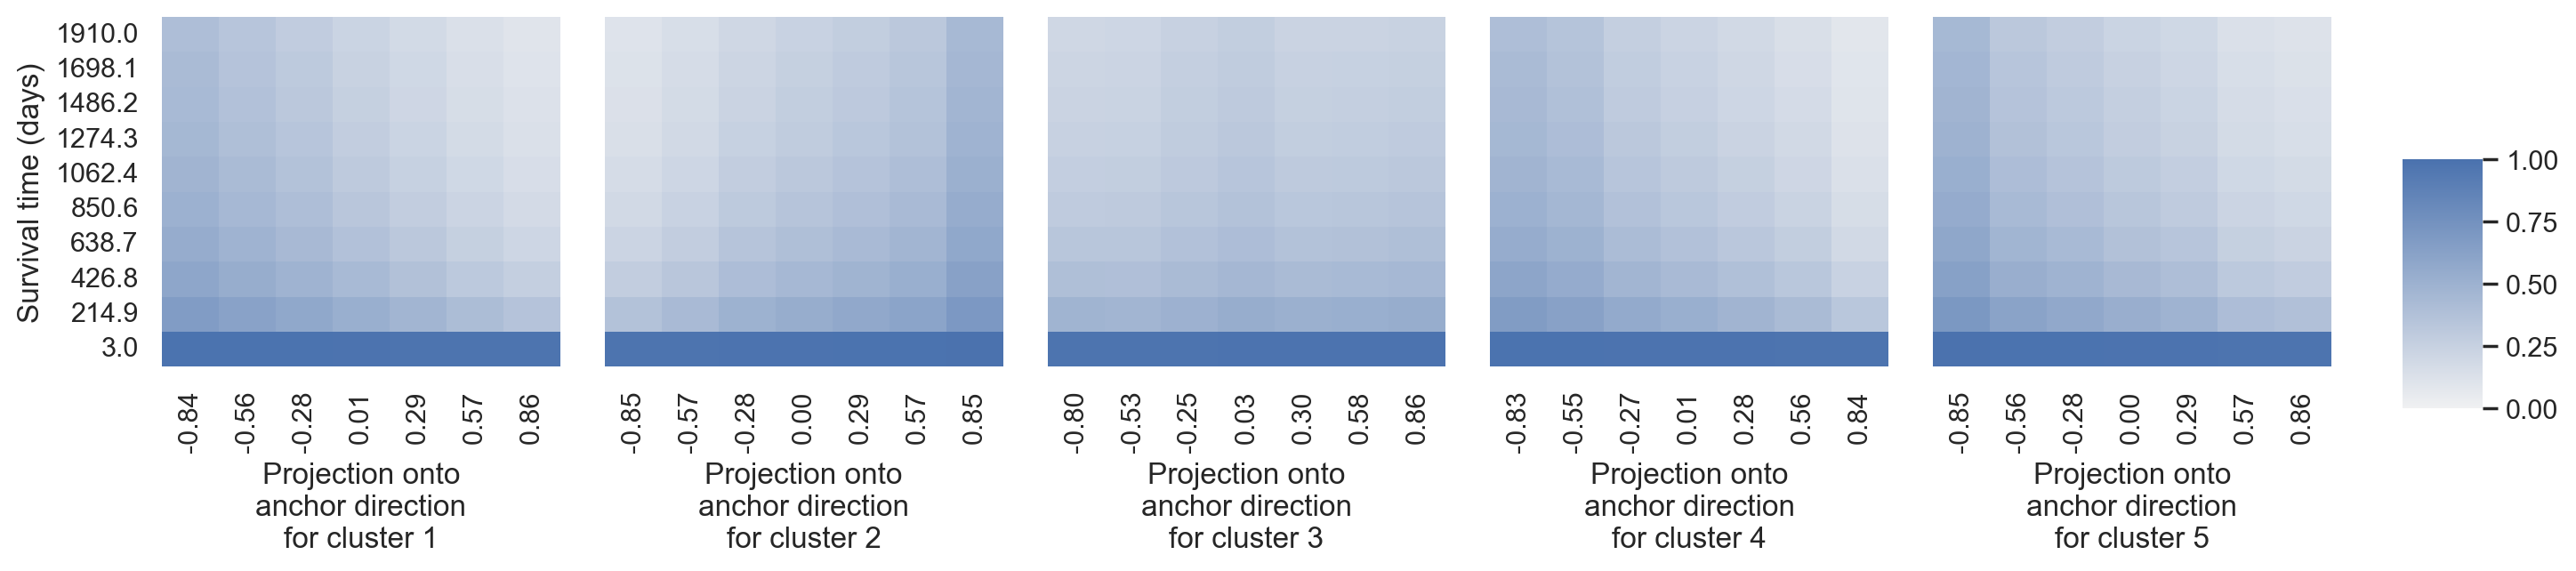

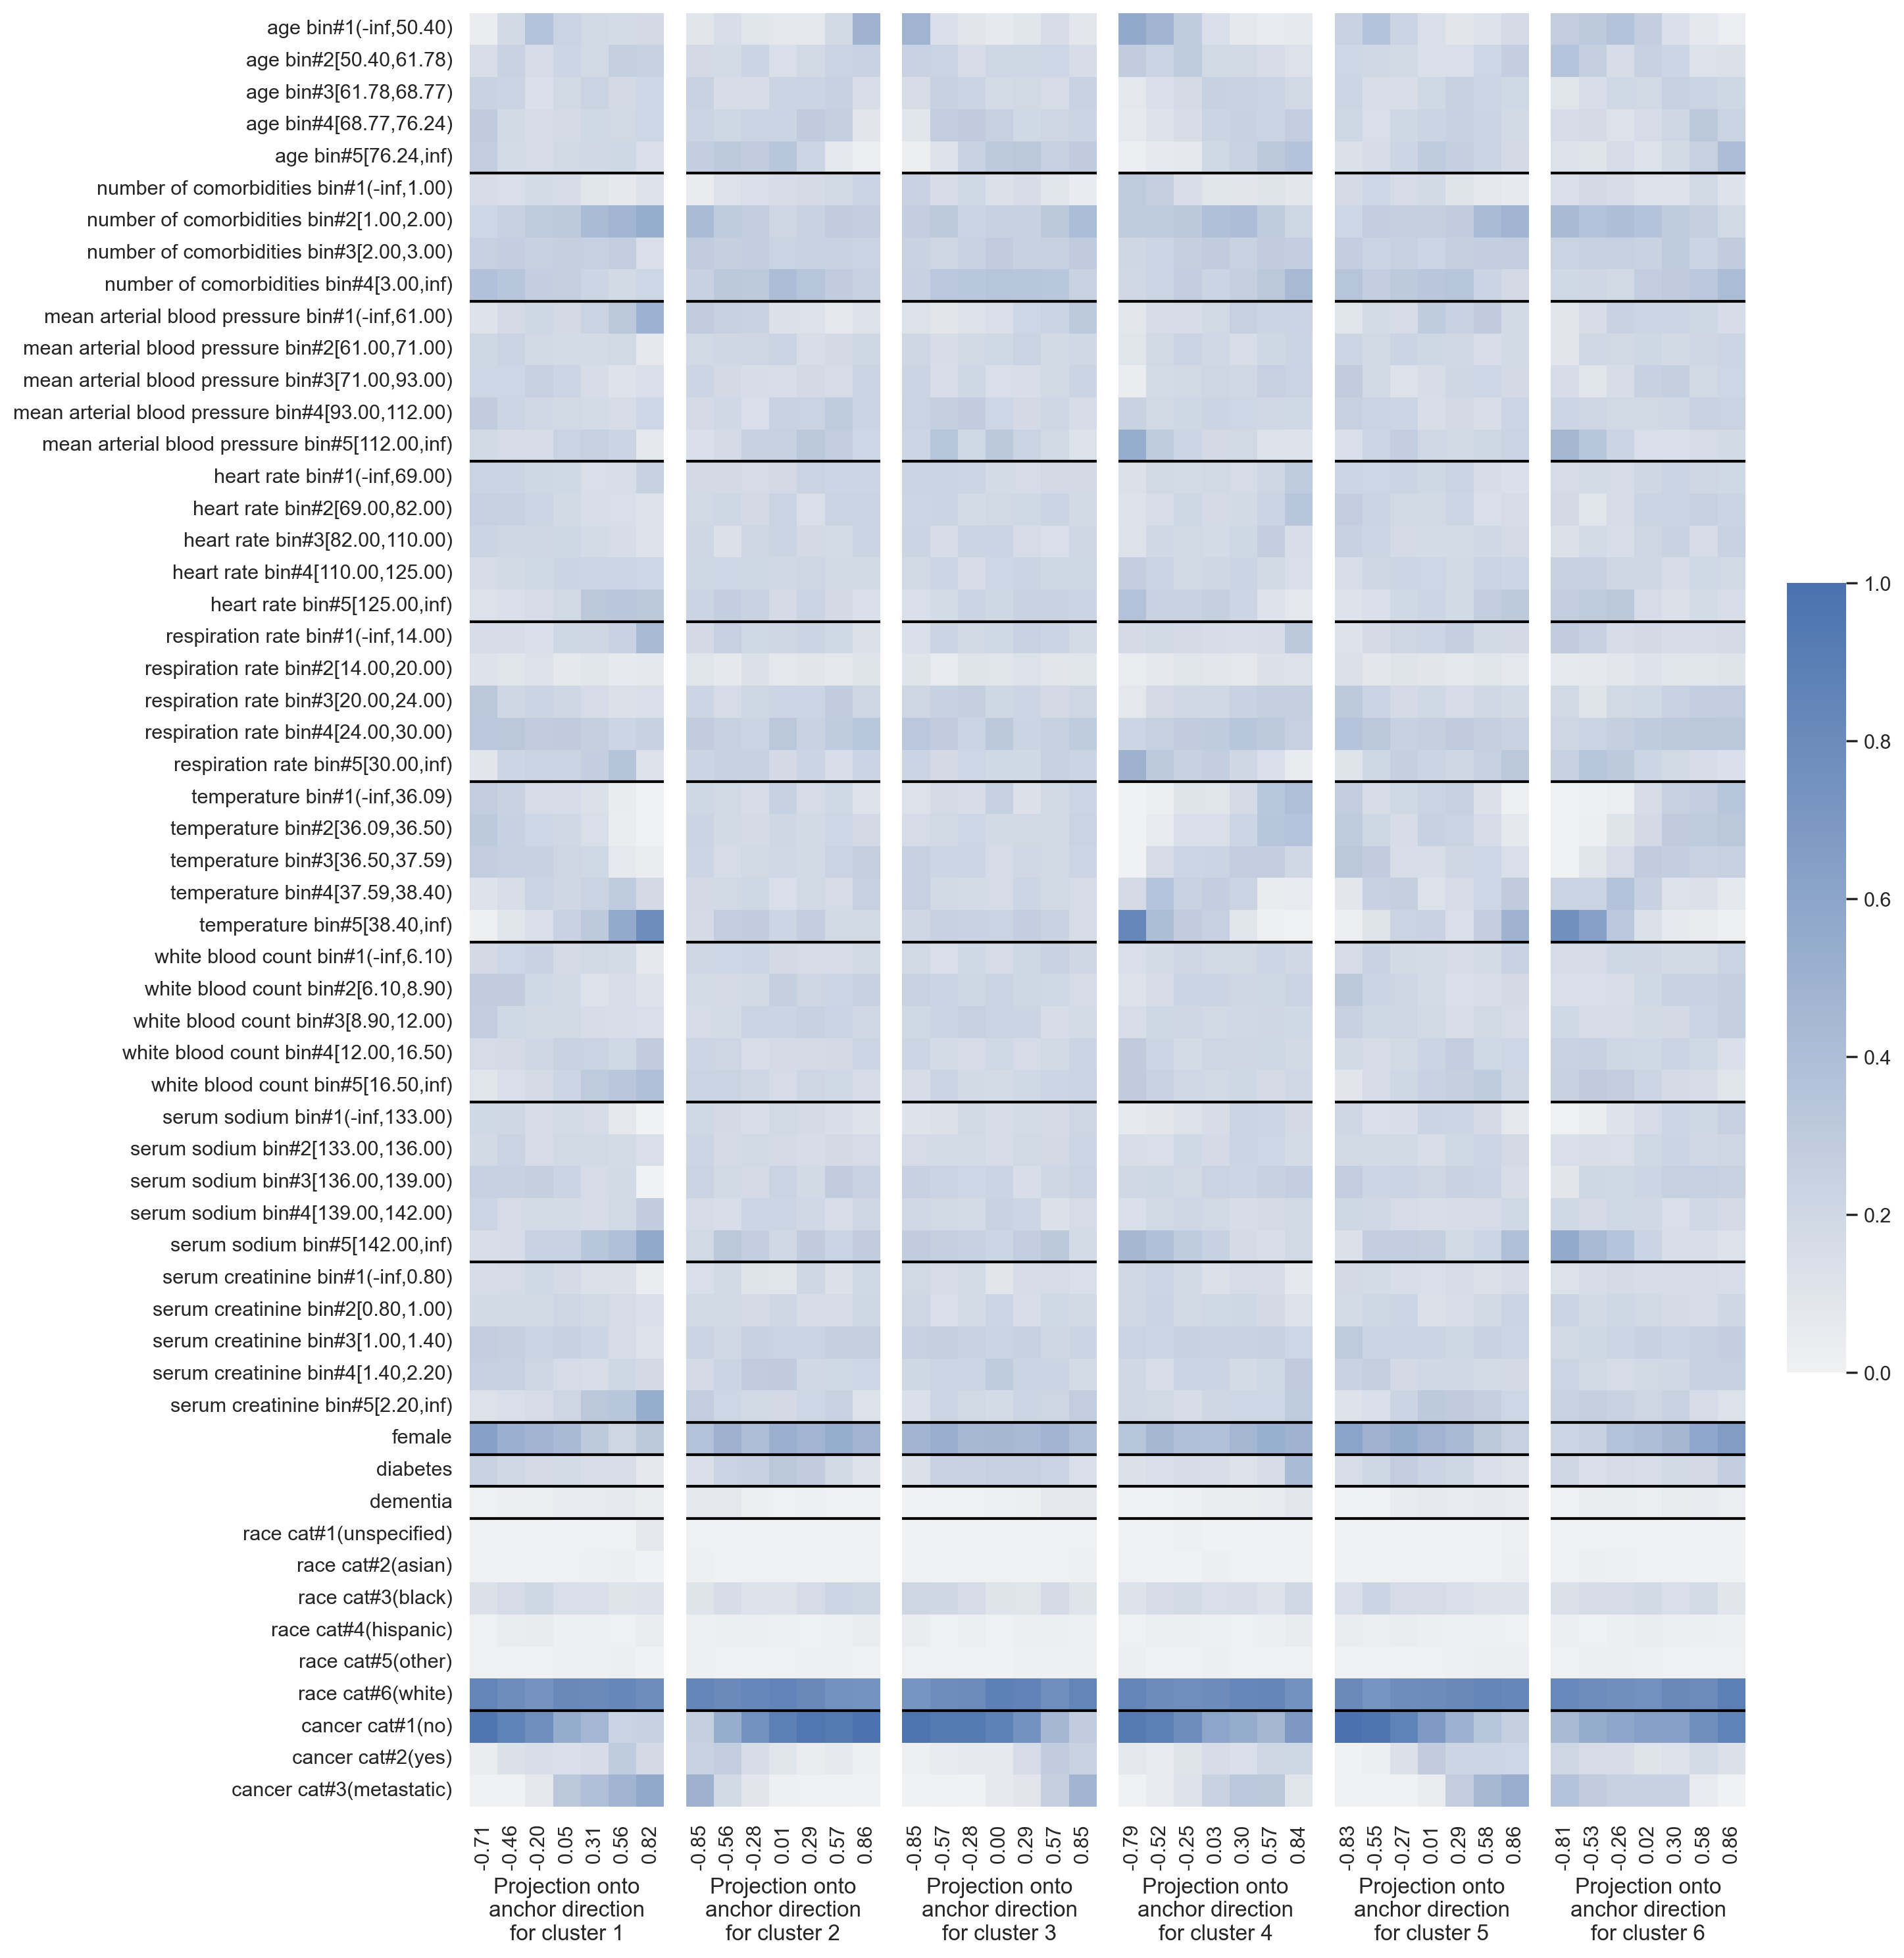

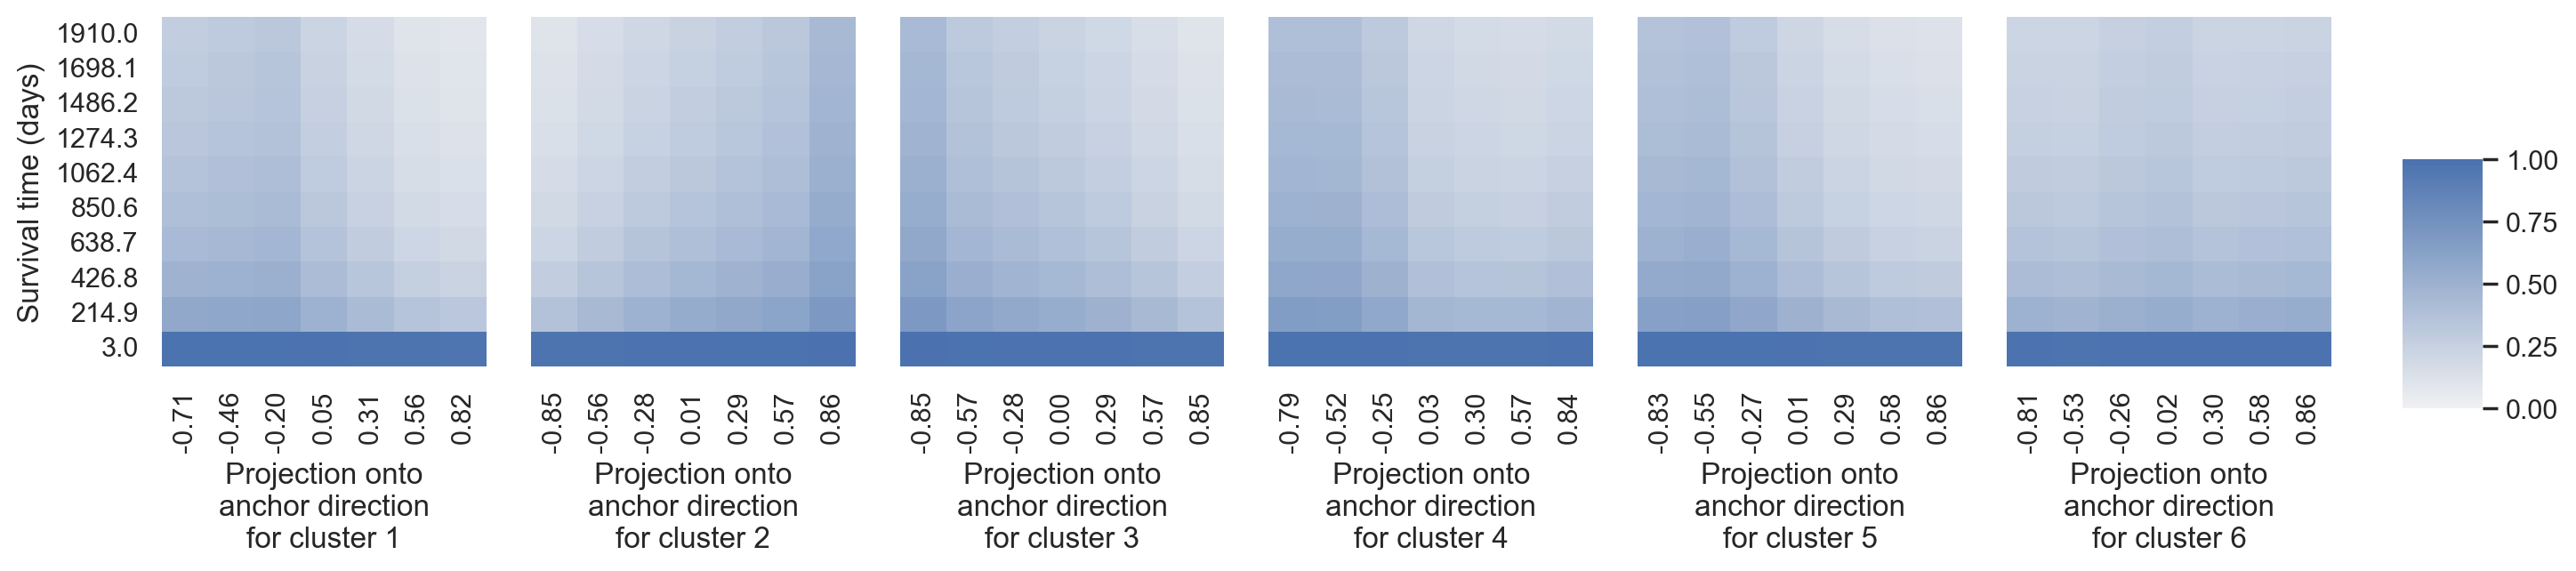

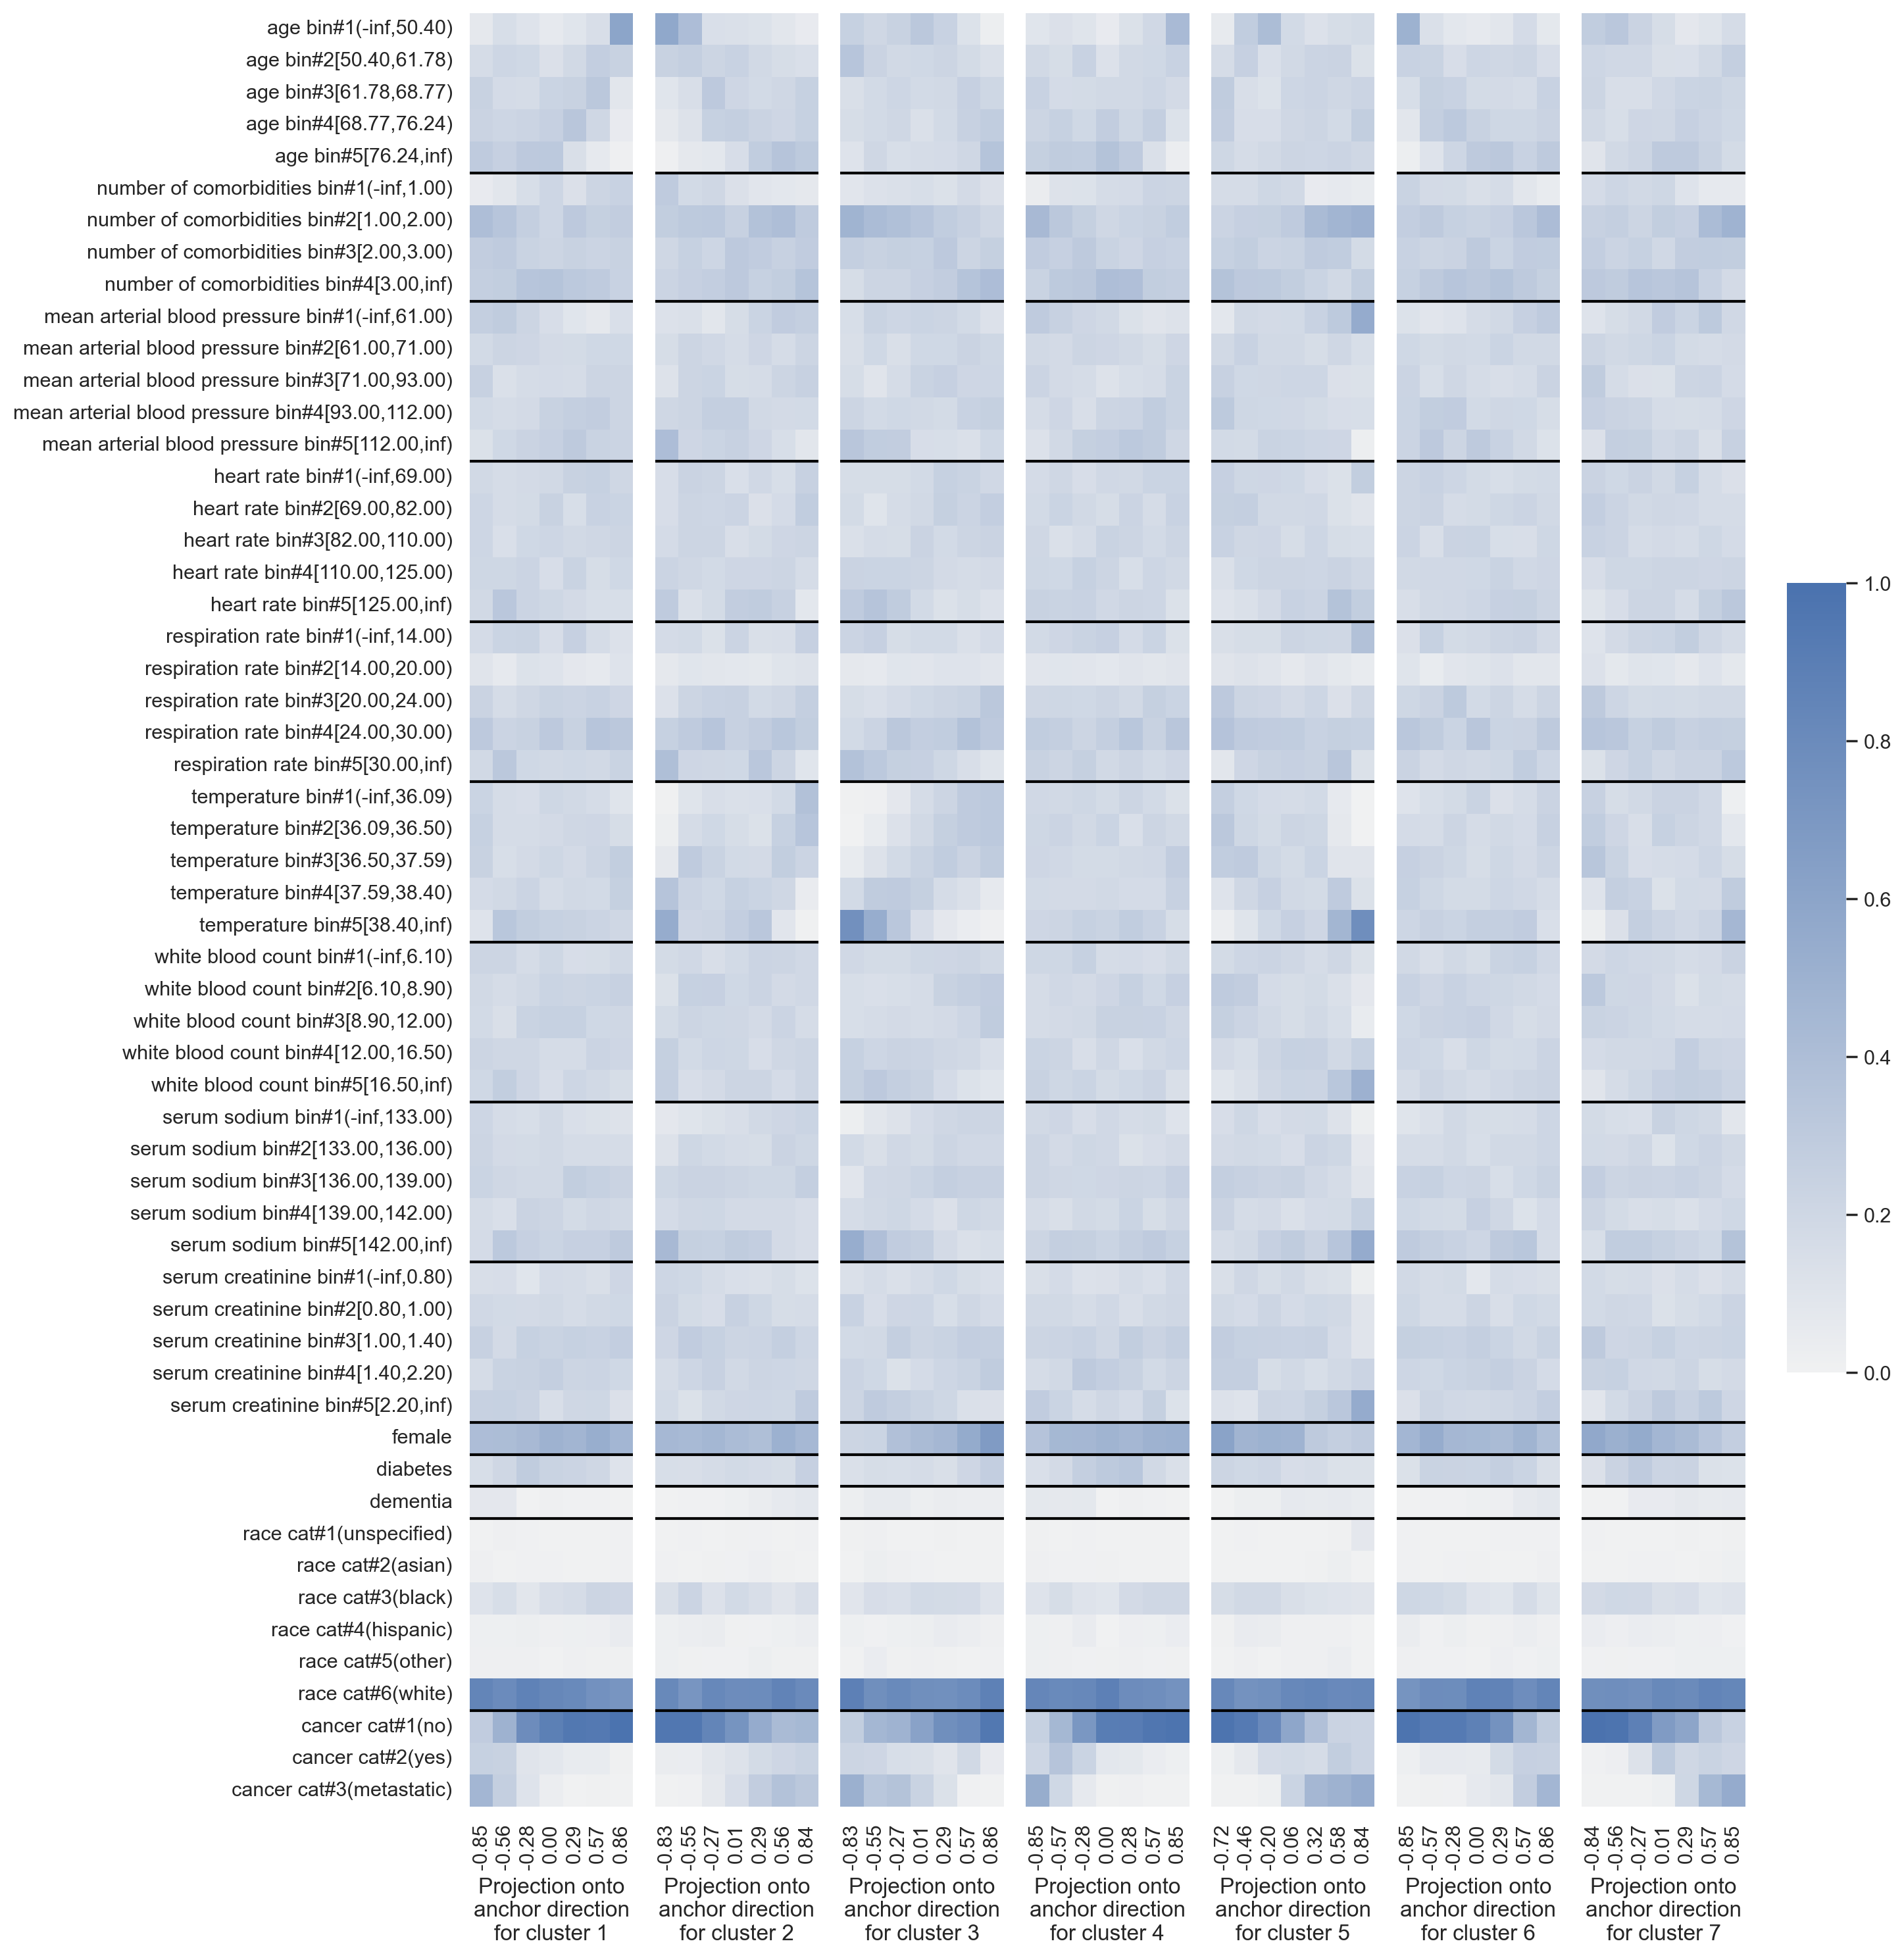

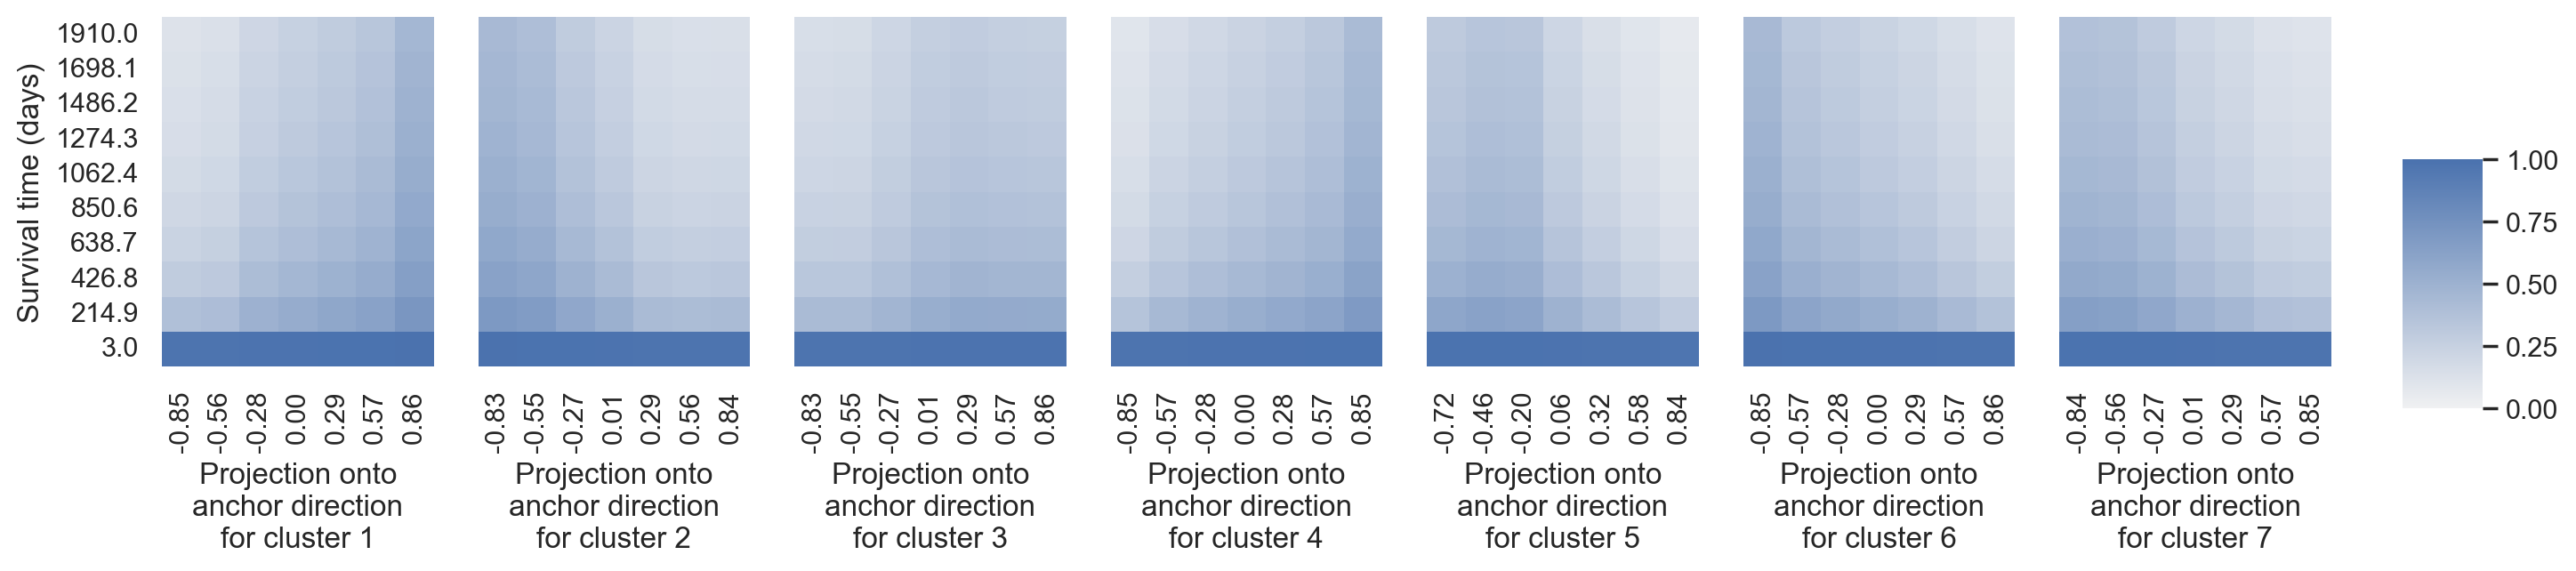

In [11]:
alpha = .1

for final_n_clusters in [3, 4, 5, 6, 7]:
    print('[Number of clusters: %d]' % final_n_clusters)
    final_cluster_assignment = cluster_assignments[n_clusters_to_try.index(final_n_clusters)]
    center_of_mass = emb_direction.mean(axis=0)
    anchor_directions = np.array([emb_direction[final_cluster_assignment == cluster_idx].mean(axis=0) - center_of_mass
                                  for cluster_idx in range(final_n_clusters)])

    all_raw_feature_probability_heatmaps = []
    all_bin_edges = []

    n_bins = 7
    emb_vis_normalized = l2_normalize_rows(emb_vis - center_of_mass[np.newaxis, :])
    anchor_directions_normalized = l2_normalize_rows(anchor_directions)
    for cluster_idx in range(final_n_clusters):
        projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

        bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
        bin_edges_copy_with_inf_right_edge = bin_edges.copy()
        bin_edges_copy_with_inf_right_edge[-1] = np.inf

        bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

        heatmap = np.zeros((len(discretized_feature_names), n_bins))
        for discretized_feature_idx in range(len(discretized_feature_names)):
            for projection_bin_idx in range(n_bins):
                heatmap[discretized_feature_idx, projection_bin_idx] = raw_vis_discretized[bin_assignments == projection_bin_idx][:, discretized_feature_idx].mean()

        all_raw_feature_probability_heatmaps.append(heatmap)
        all_bin_edges.append(bin_edges)

        # compute ranking table
        projection_bin_counts = np.array([(bin_assignments == bin_idx).sum() for bin_idx in range(n_bins)])
        print('[Cluster %d]' % (cluster_idx + 1))
        current_row = 0
        variable_pval_pairs = []
        for variable_idx in range(len(all_n_bins_to_use)):
            n_bins_to_use = all_n_bins_to_use[variable_idx]
            if n_bins_to_use >= 2:
                prefix = \
                    longest_common_prefix([discretized_feature_names[idx]
                                           for idx in range(current_row,
                                                            current_row + n_bins_to_use)])
                if prefix.endswith('(') or prefix.endswith('['):
                    prefix = prefix[:-1]
                if prefix.endswith(' cat#') or prefix.endswith(' bin#'):
                    prefix = prefix[:-5]
                prefix = prefix.strip()
                res = scipy.stats.chi2_contingency(
                    heatmap[current_row:(current_row + n_bins_to_use), :]
                    * projection_bin_counts[np.newaxis, :])
                variable_pval_pairs.append((prefix, res[1]))
            else:
                indicator_row = heatmap[current_row:(current_row + n_bins_to_use), :]
                res = scipy.stats.chi2_contingency(
                    np.array([[indicator_row, 1. - indicator_row]])
                    * projection_bin_counts[np.newaxis, :])
                # print(discretized_feature_names[current_row], res[1])
                variable_pval_pairs.append((discretized_feature_names[current_row], res[1]))
            current_row += n_bins_to_use
        for idx, (variable_name, pval) in enumerate(sorted(variable_pval_pairs, key=lambda x: x[1])):
            print(idx + 1, '-', variable_name, '-', pval)
            # print('%d &' % (idx + 1), variable_name, (('& $%.2E' % pval).replace('E-', '\\times 10^{-') + '}$ \\\\').replace('^{-0', '^{-'))
        print()

    # plot all raw feature probability heatmaps together

    n_bins = 7
    # fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(12.5, 15))
    fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(15, 15))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for cluster_idx in range(final_n_clusters):
        ax = axn.flat[cluster_idx]
        current_row = 0
        for idx, count in enumerate(all_n_bins_to_use[:-1]):
            current_row += count
            ax.plot([0, n_bins], [current_row, current_row], 'black')
        sns.heatmap(pd.DataFrame(all_raw_feature_probability_heatmaps[cluster_idx],
                                 index=discretized_feature_names,
                                 columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                               + all_bin_edges[cluster_idx][1:])/2]),
                    ax=ax,
                    cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
                    vmin=0, vmax=1,
                    cbar=(cluster_idx == 0),
                    cbar_ax=None if (cluster_idx != 0) else cbar_ax)
        ax.set_xlabel('Projection onto\nanchor direction\nfor cluster %d' % (cluster_idx + 1))
    fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
    # plt.savefig('support-raw-feature-prob-heatmaps-hypersphere.pdf', bbox_inches='tight')

    # compute survival probability heatmaps

    from scipy import interpolate

    n_rows = 10
    discrete_time_grid = np.linspace(unique_train_times.min(), unique_train_times.max(), n_rows)

    all_survival_probability_heatmaps = []
    all_projection_bin_surv_curves = []
    for cluster_idx in range(final_n_clusters):
        projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

        bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
        bin_edges_copy_with_inf_right_edge = bin_edges.copy()
        bin_edges_copy_with_inf_right_edge[-1] = np.inf

        bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

        heatmap = np.zeros((n_rows, n_bins))
        projection_bin_surv_curves = []
        for projection_bin_idx in range(n_bins):
            projection_bin_surv = interpolate.interp1d(
                unique_train_times,
                predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
            projection_bin_surv_curves.append(
                predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
            heatmap[:, projection_bin_idx] = projection_bin_surv(discrete_time_grid)[::-1]

        all_survival_probability_heatmaps.append(heatmap)
        all_projection_bin_surv_curves.append(projection_bin_surv_curves)

    # plot all survival probability heatmaps

    # fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(12.5, 3.5))
    fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(15, 3.5))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for cluster_idx in range(final_n_clusters):
        ax = axn.flat[cluster_idx]
        sns.heatmap(
            pd.DataFrame(all_survival_probability_heatmaps[cluster_idx],
                         index=['%.1f' % x for x in discrete_time_grid[::-1]],
                         columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                       + all_bin_edges[cluster_idx][1:])/2]),
            cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
            vmin=0, vmax=1, ax=ax,
            cbar=(cluster_idx == 0),
            cbar_ax=None if (cluster_idx != 0) else cbar_ax)
        ax.set_xlabel('Projection onto\nanchor direction\nfor cluster %d' % (cluster_idx + 1))
        if cluster_idx == 0:
            ax.set_ylabel('Survival time (days)')
    fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)
    # plt.savefig('support-surv-prob-heatmaps-hypersphere.pdf', bbox_inches='tight')

    # ranking anchor directions based on median survival time

    # estimate a survival curve for the top alpha fraction of visualization data points per cluster/anchor direction
    anchor_direction_median_survival_time_pairs = []
    for cluster_idx in range(final_n_clusters):
        projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])
        q_alpha = np.sort(projections)[int(np.ceil((1-alpha)*len(projections)))]

        surv_curv_alpha = predicted_surv_vis[projections >= q_alpha].mean(axis=0)
        median_surv_time_estimate = compute_median_survival_times(surv_curv_alpha, unique_train_times)
        anchor_direction_median_survival_time_pairs.append((cluster_idx, median_surv_time_estimate))

    # sort anchor directions by median survival time estimates
    sorted_anchor_direction_median_survival_time_pairs = \
        sorted(anchor_direction_median_survival_time_pairs, key=lambda x: x[1])
    for cluster_idx, median_survival_time in sorted_anchor_direction_median_survival_time_pairs:
        print('Cluster', cluster_idx + 1, ': median survival time estimate', median_survival_time)
    print()
    print()